In [11]:
'''
Creates training data for ATMS channel predictor
'''


import numpy as np
import xarray as xr
import glob
from tqdm import tqdm
from util_funcs.L1C import scantime2datetime
from util_funcs import data2xarray, array_funcs
import geography

import sensor_info
import local_functions

satellite = sensor_info.satellite
sensor = sensor_info.sensor

datapath = f'/pdata4/archive/GPM/1C_NOAA20_V7'

In [6]:
'''
Satellite: NOAA20

Get data and quality check for training.

nscans: generally around 2300
npixs: 96

    
Tb array will be set up as follows:
    Tbs =  [m x n], where m is the number of samples and n is
    the
           number of channels (features)

    1:     23.8 QV
    2:     31.4 QV
    3:     88.2 QV
    4:    165.5 QH
    5:    183.31+-7 QH
    6:    183.31+-4.5 QH
    7:    183.31+-3 QH
    8:    183.31+-1.8 QH
    9:    183.31+-1 QH
'''

#Set up a random seed for reproducibility
np.random.seed(12)

#Get a random list of files
file_list = glob.glob(f'{datapath}/*/*/1C.{satellite}.{sensor}.*.HDF5'); file_list.sort()

#Cut data off at 2211 since we don't have surface maps for dates after this:
good_files = [ifile for ifile in file_list if int(ifile.split('/')[5]) <= 2211]

flist = np.random.choice(good_files, size=1000)



#Loop through files and get good quality data.
for i, ifile in enumerate(tqdm(flist, desc="Processing Files")):

    #print(f'{i+1} of {len(flist)}, {ifile}')

    data = local_functions.read_atms_l1c(ifile)

    lat = data['lat']
    lon = data['lon']
    scantime = data['scantime']
    Tbs = data['Tbs']
    qual = data['qual']
    #Just use eia from scan 2
    eia  = data['eia'][:,:,1]


    #For crosstrack scanners, use pixel position as a predictor
    scanpos = np.zeros(lat.shape, dtype=np.int32)
    scanpos[:,0:lat.shape[1]//2] = np.arange(lat.shape[1]//2-1,-1,-1)
    scanpos[:,lat.shape[1]//2:]  = np.arange(0, lat.shape[1]//2)


    #Get only good quality data and reshape:
    goodqual = np.all(qual == 0, axis=2)
    all_bad = np.all(goodqual == False)
    if all_bad:
        print('all were bad.')
        continue
    lat = lat[goodqual]
    lon = lon[goodqual]
    scantime = scantime[np.where(goodqual)[0]]
    Tbs = Tbs[goodqual]
    scanpos = scanpos[goodqual]
    eia     = eia[goodqual]

    #Check for NaNs (shouldn't be any if all good, but I've seen some)
    nonans = local_functions.find_nan_rows(Tbs, return_good=True)
    Tbs = Tbs[nonans]
    lat = lat[nonans]
    lon = lon[nonans]
    scantime = scantime[nonans]
    scanpos  = scanpos[nonans]
    eia      = eia[nonans]
    

    #Attach GPROF surface map data to each pixel
    sfctype = local_functions.attach_gpm_sfctype(lat, lon, scantime, sensor=sensor)

    raise

    npixs = lat.size

    #Output as NetCDF
    dset = data2xarray(data_vars = [lat, lon, scantime, sfctype, Tbs, scanpos, eia],
                       var_names = ['latitude', 'longitude', 'scantime', 'sfctype', 'Tbs', 'scanpos', 'eia'],
                       dims = [npixs, sensor_info.nfeatures],
                       dim_names = ['pixels', 'channels'])


    if i == 0:
        training_dataset = dset
    else:
        training_dataset = xr.concat((training_dataset, dset), dim='pixels')

training_dataset.to_netcdf(f'training_data/{satellite}_training_data.nc', engine='netcdf4')

Processing Files:   0%|                                                                                                              | 0/1000 [00:05<?, ?it/s]


RuntimeError: No active exception to reraise

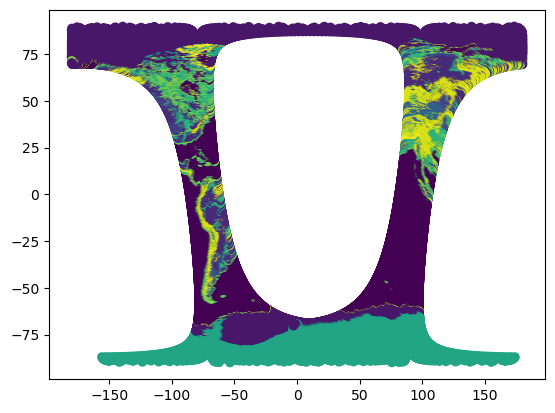

In [8]:
import matplotlib.pyplot as plt

plt.scatter(lon, lat, c=sfctype)

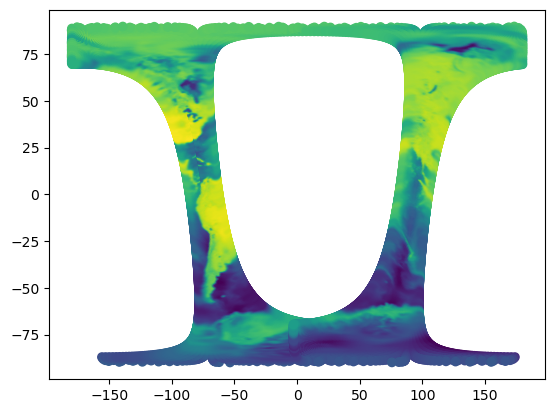

In [10]:
plt.scatter(lon,lat,c=Tbs[:,0])

In [4]:
eia

array([[64.3 , 62.57, 60.89, ..., 61.08, 62.77, 64.52],
       [64.3 , 62.57, 60.89, ..., 61.08, 62.77, 64.52],
       [64.29, 62.57, 60.89, ..., 61.08, 62.76, 64.51],
       ...,
       [64.27, 62.55, 60.89, ..., 61.1 , 62.76, 64.5 ],
       [64.27, 62.55, 60.89, ..., 61.1 , 62.77, 64.5 ],
       [64.27, 62.55, 60.88, ..., 61.11, 62.77, 64.5 ]],
      shape=(2283, 96), dtype=float32)

In [5]:
scanpos

array([[47, 46, 45, ..., 45, 46, 47],
       [47, 46, 45, ..., 45, 46, 47],
       [47, 46, 45, ..., 45, 46, 47],
       ...,
       [47, 46, 45, ..., 45, 46, 47],
       [47, 46, 45, ..., 45, 46, 47],
       [47, 46, 45, ..., 45, 46, 47]], shape=(2283, 96), dtype=int32)

In [5]:
with xr.open_dataset(ifile, group='S4') as f:
    lat = f.Latitude.values
    lon = f.Longitude.values
    eia = f.incidenceAngle.values

/tmp/ipykernel_3728353/1297937231.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  with xr.open_dataset(ifile, group='S4') as f:


In [6]:
eia.shape

(2283, 96, 1)

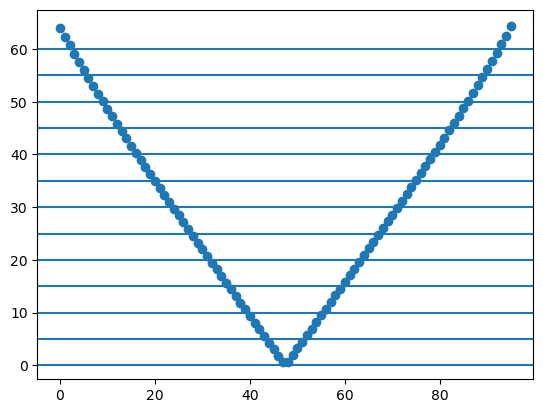

In [15]:
import matplotlib.pyplot as plt

anglebins = np.arange(0,65,5)

plt.scatter(np.arange(0,96),np.mean(eia[:,:,0], axis=0))
for i,ang in enumerate(anglebins):
    plt.axhline(anglebins[i])

In [9]:
np.arange(0,60,5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])

In [13]:
with xr.open_dataset(f'training_data/{satellite}_training_data.nc') as f:
    sfctype = f.sfctype.values

for i in range(18):
    print(f'Number of pixels with surface type {i}: {np.sum(sfctype == i)}')

print(f'Total: ', sfctype.size)

Number of pixels with surface type 0: 0
Number of pixels with surface type 1: 115044867
Number of pixels with surface type 2: 21425996
Number of pixels with surface type 3: 6865483
Number of pixels with surface type 4: 4367169
Number of pixels with surface type 5: 3722808
Number of pixels with surface type 6: 2034748
Number of pixels with surface type 7: 3673792
Number of pixels with surface type 8: 1556595
Number of pixels with surface type 9: 1552269
Number of pixels with surface type 10: 4377198
Number of pixels with surface type 11: 21551800
Number of pixels with surface type 12: 4061169
Number of pixels with surface type 13: 2780238
Number of pixels with surface type 14: 3353400
Number of pixels with surface type 15: 2654783
Number of pixels with surface type 16: 1190428
Number of pixels with surface type 17: 8635868
Total:  213240809


In [25]:
xr.open_dataset(f'training_data/{satellite}_training_data.nc')

array([0, 1, 2, ..., 2, 1, 0], shape=(42679791,), dtype=int32)